# Summary

## Task

To explore dependency parsing for sentences so that word level graphs can be constructed for the problem of classification

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## Method

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spektral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.

## Dataset

The dataset is still IMDB review but we may expand later on

## Results

Fill in later

## Conclusion

Fill in at the end

# Code

## Basic Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import spacy

In [ ]:
stanza.download('en')

In [ ]:
import stanzaTools

## Part 1: Dependency Parsing

### Testing Stanza

In [ ]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well! Ok this might be kind of difficult."

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(sampleSentence)

In [ ]:
doc.sentences[0]

In [ ]:
sent_dict = doc.sentences[0].to_dict()

#### tokenRelationHead

In [ ]:
stanzaTools.tokenRelationHead(sent_dict)

#### getNodeEdgeLists

In [ ]:
def getNodeEdgeLists(doc):
    """
    Parses all the edges in sent_dict and extracts the edges, node labels, and edge labels.
    Args:
        doc - (stanza.models.common.doc.Document) The doc object
    Returns:
        nodeList - (list) A list of dictionaries, the keys are the same as the items inside a sentence object.
        edgeList - (list) A list of dictionaries, the keys are "edgePair", "edgeLabel"
    """
    edgeList = []
    nodeList = []
    modifier = 0 
    wordLimit = 50
    maxSentences = 3
    sentences = []
    for sentence in doc.sentences:
        if sentence.sentiment != 1:
            sentences.append(sentence)
    sentences = sentences[0:3]
    for sentence in sentences:
        for node in sentence.to_dict()[0:wordLimit]:
            node['id'] += modifier
            node['head'] += modifier
            nodeList.append(node)
            
            # if modifier and node['id'] == modifier + 1:
            #     edgePair = (node['id'] - 1, node['id'])
            #     edgeLabel = 'nextSentence'
            #     edgeList.append(
            #         {
            #             "edgePair" : edgePair,
            #             "edgeLabel" : edgeLabel
            #         }
            #     )
            if (node['head'] != modifier and node['head'] <= modifier + wordLimit):
                # the first is the head and the second is dependent
                edgePair = (node['head'], node['id'])
                edgeLabel = node['deprel']
                edgeList.append(
                    {
                        "edgePair" : edgePair,
                        "edgeLabel" : edgeLabel,
                    }
                )
        modifier += len(sentence.to_dict()[0:wordLimit])

    return nodeList, edgeList

In [ ]:
doc

In [ ]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

In [ ]:
doc

In [ ]:
nodeList

#### drawDepGraph

In [ ]:
stanzaTools.drawDepGraph(nodeList, edgeList)

### Testing Spacy (Ignore for Now)

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = sampleSentence
doc = nlp(text)
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)    

In [ ]:
spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

In [ ]:
doc

### Testing TF Datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import spacy
import tfDatasetTools
nlp = spacy.load("en_core_web_sm")

In [ ]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

In [ ]:
part = testDS.take(10)

#### decodeZeroDimTensor

#### convertTakeDataset

In [ ]:
features, labels = tfDatasetTools.convertTakeDataset(part)

In [ ]:
features[0]

In [ ]:
labels

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(features[1])
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

In [ ]:
doc.sentences[1]

### Testing spektral

In [ ]:
import spektral
from spektral.datasets import TUDataset

In [ ]:
dataset = TUDataset('PROTEINS')

In [ ]:
dataset

In [ ]:
train_datset = dataset[:100]

In [ ]:
test_datset = dataset[100:]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool

In [ ]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [ ]:
model = MyFirstGNN(32, dataset.n_labels)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from spektral.data import BatchLoader

loader = BatchLoader(train_datset, batch_size=32)
testLoader = BatchLoader(test_datset, batch_size=32)

In [ ]:
model.fit(loader.load(),steps_per_epoch=loader.steps_per_epoch, epochs=10)

In [ ]:
model.evaluate(testLoader.load(),steps=testLoader.steps_per_epoch)

In [ ]:
test_datset[12].y

## Part 2: Graph Networks

### Basic Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import tensorflow_hub as hub
import tensorflow_text
import spektral

In [2]:
import stanzaTools
import tfDatasetTools

### Set up Stanza

In [3]:
stanza.download('en')

2022-05-26 23:14:06 INFO: Downloading default packages for language: en (English)...
2022-05-26 23:14:07 INFO: File exists: /Users/zeyuyang/stanza_resources/en/default.zip
2022-05-26 23:14:10 INFO: Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


In [4]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-05-26 23:14:10 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-05-26 23:14:11 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-05-26 23:14:11 INFO: Use device: cpu
2022-05-26 23:14:11 INFO: Loading: tokenize
2022-05-26 23:14:11 INFO: Loading: pos
2022-05-26 23:14:11 INFO: Loading: lemma
2022-05-26 23:14:11 INFO: Loading: depparse
2022-05-26 23:14:11 INFO: Loading: sentiment
2022-05-26 23:14:11 INFO: Done loading processors!


#### createGraph

In [5]:
from importlib import reload
reload(stanzaTools)
reload(tfDatasetTools)

<module 'tfDatasetTools' from '/Users/zeyuyang/Projects/CS397Project/tfDatasetTools.py'>

In [6]:
def createGraph(doc, positive):
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToEmbedding(words, preprocessor, encoder)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    label = np.array([positive])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, label)

### Load Data

In [7]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

Metal device set to: Apple M1 Max


2022-05-26 23:14:35.041123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 23:14:35.041361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Set a Limit

In [8]:
trainLimit = 2000
testLimit = 2000

trainSubset = trainDS.take(trainLimit)
testSubset = testDS.take(testLimit)

In [9]:
validationSplit = 0.5
validationIndex = int(validationSplit * trainLimit)

validationSplitSubset = trainSubset.take(validationIndex)
trainSplitSubset = trainSubset.skip(validationIndex)

In [11]:
trainFeatures, trainLabels = tfDatasetTools.convertTakeDataset(trainSplitSubset)
valFeatures, valLabels = tfDatasetTools.convertTakeDataset(validationSplitSubset)
testFeatures, testLabels = tfDatasetTools.convertTakeDataset(testSubset)

2022-05-26 23:14:57.261259: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-26 23:14:57.384469: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-26 23:14:57.454741: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-26 23:14:57.619468: W t

In [21]:
print(trainFeatures[0])

"They Are Among Us" is poor science fiction at best. Mediocre acting bogs down this film. The plot holes are numerous. Aliens that somehow came to earth on a meteor and have been hiding among us for over 100 years, but need a plastic surgeon to make them appear human. In their alien form they supposedly have exo-skeletons (which is why they need the plastic surgery) but when you see them they have teeth and fingernails. The heroine's father "disappeared" after Project Blue Book closed, but was supposedly an F-16 pilot. And on and on. If you want to see an alien invasion movie, pick "Invasion of the Body Snatchers", and see how it is done right.


In [17]:
doc = nlp(trainFeatures[0])

In [20]:
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

"They Are Among Us" is poor science fiction at best.
0
Mediocre acting bogs down this film.
0
The plot holes are numerous.
0
Aliens that somehow came to earth on a meteor and have been hiding among us for over 100 years, but need a plastic surgeon to make them appear human.
0
In their alien form they supposedly have exo-skeletons (which is why they need the plastic surgery) but when you see them they have teeth and fingernails.
0
The heroine's father "disappeared" after Project Blue Book closed, but was supposedly an F-16 pilot.
0
And on and on.
1
If you want to see an alien invasion movie, pick "Invasion of the Body Snatchers", and see how it is done right.
1


In [18]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

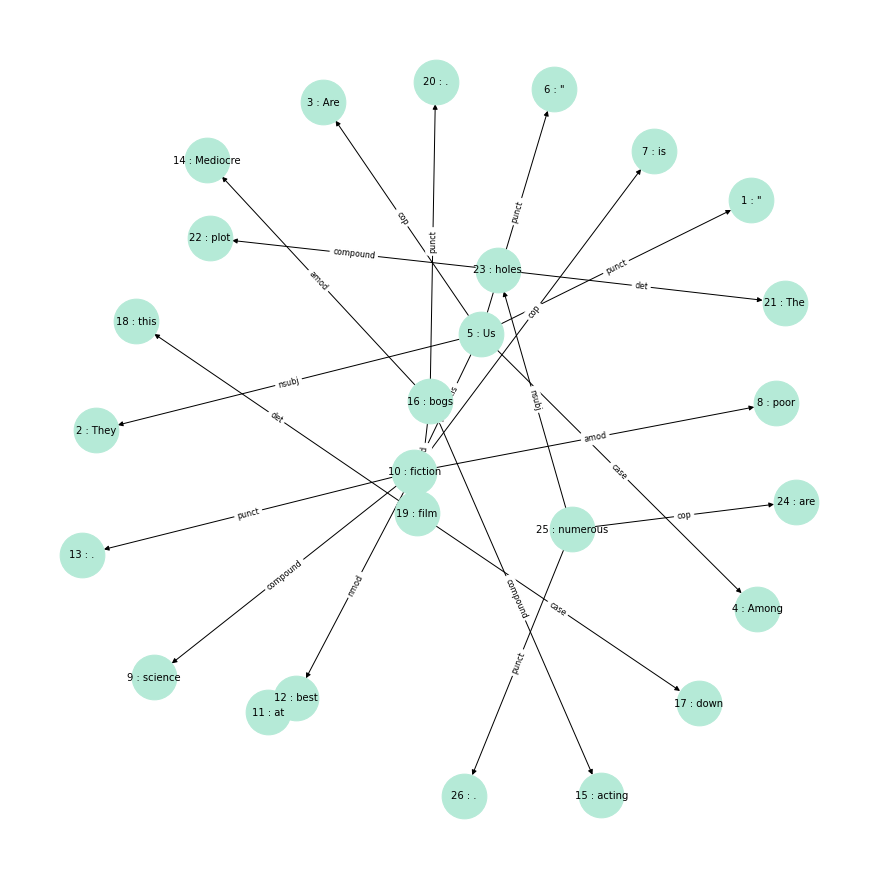

In [19]:
stanzaTools.drawDepGraph(nodeList, edgeList)

#### Bert Embeddings

In [15]:
tf.keras.backend.clear_session()

In [16]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=False)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-26 23:15:34.888157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-26 23:15:35.705241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


#### Convert to Embedding

In [ ]:
def convertToEmbedding(words, preprocessor, encoder):
    """
    Takes a list of words and converts it to a list of embeddings. 
    
    Args:
        words - (list) The list of words to convert
        preprocessor - (tensorflow_hub.keras_layer.KerasLayer) The preprocessor needed to process a string to tokens
        encoder - (tensorflow_hub.keras_layer.KerasLayer) The encoder needed to convert the tokens to embeddings
    Returns:
        embeddings - (list) A list of embeddings
    """
    
    convertedWords = np.array(encoder(preprocessor(tf.constant(words)))['pooled_output'])
    return convertedWords

In [ ]:
text = "hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you"
words = text.split()
converted = convertToEmbedding(words, preprocessor, encoder)

In [ ]:
converted.shape

In [ ]:
converted = convertToEmbedding(['!'], preprocessor, encoder)

In [ ]:
word = ['hello', 'there']
convertedWords = convertToEmbedding(word, preprocessor, encoder)

In [ ]:
convertedWords.shape

In [ ]:
def sampleModel():
    inputs = text_input
    preprocessorLayer = preprocessor(inputs)['input_word_ids']
    
    embedding_layer = tf.keras.layers.Embedding(10000,
                                                128)(preprocessorLayer)
    # embedding_layer = encoder(preprocessorLayer)['pooled_output']
    
    flatten = tf.keras.layers.Flatten()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(flatten)
    outputs = tf.keras.layers.Dense(1)(dense_layer)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
tf.keras.backend.clear_session()
model = sampleModel()
model.summary()

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    trainFeatures,
    trainLabels,
    validation_data=(valFeatures, valLabels),
    epochs=20,
    verbose=1)

In [ ]:
results = model.evaluate(x=testFeatures, y=testLabels)
print(results)

### Convert Data to Graph Format

In [ ]:
trainGraphs = []

for i in range(len(trainFeatures)):
    sentence = trainFeatures[i]
    label = trainLabels[i]
    doc = nlp(sentence)
    newGraph = createGraph(doc, label)
    trainGraphs.append(newGraph)

In [ ]:
len(trainGraphs)

In [ ]:
validationGraphs = []

for i in range(len(valFeatures)):
    sentence = valFeatures[i]
    label = valLabels[i]
    doc = nlp(sentence)
    newGraph = createGraph(doc, label)
    validationGraphs.append(newGraph)

In [ ]:
len(validationGraphs)

In [ ]:
[i.shape for i in np.array(trainGraphs)[:,1]]

#### Custom Graph Datasets

In [ ]:
from spektral.data import Dataset 
from spektral.data.graph import Graph
import os

In [ ]:
class TrainDataset(Dataset):
    """
    A dataset of five random graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        # self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(trainGraphs)):
            # print(type(trainGraphs[i][0]))
            x = trainGraphs[i][0]
            a = trainGraphs[i][1]
            # a = tf.sparse.from_dense(trainGraphs[i][1])
            y = trainGraphs[i][2]

            filename = os.path.join(self.path, f'graph_{i}')
            np.savez(filename, x=x, a=a, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(trainGraphs)):
            data = np.load(os.path.join(self.path, f'graph_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], y=data['y'])
            )
        return output

In [ ]:
class ValDataset(Dataset):
    """
    A dataset of five random graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        # self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(validationGraphs)):
            # print(type(trainGraphs[i][0]))
            x = validationGraphs[i][0]
            a = validationGraphs[i][1]
            # a = tf.sparse.from_dense(validationGraphs[i][1])
            y = validationGraphs[i][2]

            filename = os.path.join(self.path, f'graph_val_{i}')
            np.savez(filename, x=x, a=a, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(validationGraphs)):
            data = np.load(os.path.join(self.path, f'graph_val_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], y=data['y'])
            )
        return output

In [ ]:
TrainDataset()

In [ ]:
ValDataset()

In [ ]:
valSaveDir = "/Users/zeyuyang/spektral/datasets/ValDataset"
trainSaveDir = "/Users/zeyuyang/spektral/datasets/TrainDataset"

In [ ]:
for i in range(1):
    data = np.load(os.path.join(trainSaveDir, f'graph_{i}.npz'), allow_pickle=True)

In [ ]:
graphTup = tuple([data[i] for i in data])

### Model and Training

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool

In [ ]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.graph_conv2 = GCNConv(16)
        self.pool = GlobalSumPool()
        self.AGNNCONV = spektral.layers.AGNNConv(trainable=True, aggregate='sum', activation=None)
        self.GenConv = spektral.layers.GeneralConv(channels=n_hidden, batch_norm=True, dropout=0.0, aggregate='sum', activation='prelu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
        self.graphAtten = spektral.layers.GATConv(channels=n_hidden, attn_heads=5,
                                                  concat_heads=True, dropout_rate=0.2, return_attn_coef=False,
                                                  add_self_loops=True, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                                  bias_initializer='zeros', attn_kernel_initializer='glorot_uniform', kernel_regularizer=None,
                                                  bias_regularizer=None, attn_kernel_regularizer=None, activity_regularizer=None,
                                                  kernel_constraint=None, bias_constraint=None, attn_kernel_constraint=None)
        self.maxPool = spektral.layers.GlobalMaxPool()
        self.dropout = Dropout(0.2)
        self.dense1 = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense2 = Dense(16, activation='relu')
        self.dense = Dense(1, 'sigmoid')

    def call(self, inputs):
        # sparseList = []
        # for i in range(inputs[1].shape[0]):
        #     converted = tf.sparse.from_dense(inputs[1][i])
        #     sparseList.append(converted)
        # print(sparseList)
        # newInput = tuple([inputs[0], sparseList])
        # inputs[1] = sparseList
        # newInput = tf.Tensor([inputs[0], inputs[1], inputs[2]])

        # out = self.AGNNCONV(inputs)
        out = self.graph_conv(inputs)
        # out = self.graphAtten(inputs)
        # print(out.shape)
        
        # out = self.graph_conv(inputs)
        # out = self.dropout(out)        
        # out = self.pool(out)
        out = self.maxPool(out)
        # out = self.dense1(out)
        out = self.dropout2(out)
        # out = self.dense2(out)
        out = self.dense(out)

        return out

In [ ]:
tf.keras.backend.clear_session()
model = MyFirstGNN(64, 1)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy',])

In [ ]:
from spektral import models

In [ ]:
# tf.keras.backend.clear_session()
# model = spektral.models.general_gnn.GeneralGNN(1, activation=None, hidden=256, message_passing=4, pre_process=2, post_process=2, connectivity='cat', batch_norm=True, dropout=0.0, aggregate='sum', hidden_activation='prelu', pool='sum')
# model.compile('adam', 'binary_crossentropy', metrics=['accuracy',])

In [ ]:
from spektral.data import BatchLoader

# trainLoader = BatchLoader(TrainDataset(), batch_size=10)
trainLoader = spektral.data.loaders.DisjointLoader(TrainDataset(), node_level=False, batch_size=10, epochs=None, shuffle=True)

# testLoader = BatchLoader(ValDataset(), batch_size=10)
testLoader = spektral.data.loaders.DisjointLoader(ValDataset(), node_level=False, batch_size=10, epochs=None, shuffle=True)

In [ ]:
for i in trainLoader.load():
    print(i)

In [ ]:
model.fit(trainLoader.load(), steps_per_epoch=trainLoader.steps_per_epoch,epochs=20)

In [ ]:
model.evaluate(testLoader.load(), steps=testLoader.steps_per_epoch)
# model.evaluate(trainLoader.load(), steps=trainLoader.steps_per_epoch)

In [ ]:
model.predict(testLoader.load(), steps=testLoader.steps_per_epoch)

### Evaluation